# Demo

In [1]:
from qiskit.circuit import QuantumCircuit

from samplomatic import Twirl, build

### Boxes

A ``box`` is just a circuit intstruction that itself holds instructions.
In otherwords, it is a scope, and can be added to a circuit in a similar way as other
scoping constructs like ``if_else``.
For scheduling purposes, a plain box, such as in the example below, is
equivalent to placing its content between two barriers of the same height.

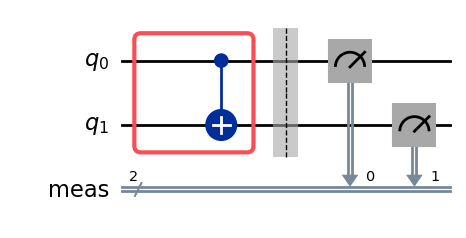

In [7]:
circuit = QuantumCircuit(2)

with circuit.box():
    circuit.cx(0, 1)

circuit.measure_all()

circuit.draw("mpl")

### Annotating Boxes for Pauli Twirling

Boxes can optionally own annotations.
Assigning a box a `Twirl` annotation indicates that the box should
be treated as a dressed twirling box.
A _dressed box_ is a generalization of the notion of a _dressed layer_, which is in turn 
a circuit layer of interest (e.g. collection of non-overlapping entanglers of interest)
composed with a round of randomized single-qubit gates.
This composition can happen either on the left or the right as a matter of convention, and
these single-qubit gates are called the _dressing_.
Any single-qubit gates in the base circuit, before randomization, are composed into the dressing
so as not to increase circuit depth.
Therefore the factors of the dressing are often expressed in terms of a fixed decomposition, such as
 `rz(a)-sx-rz(b)-sx-rz(c)`, to accomodate any U(2) operation.

Given this, a `Twirl` has two configurations:
 - `decomposition`: either `"rzsx"` (default) or `"rzrx"`
 - `dressing`: either `"left"` (default) or `"right"`

These configurations could be extended in the future, for example to allow certain kinds of randomized 
decompositions, or to modify idling qubit dressing behaviour.

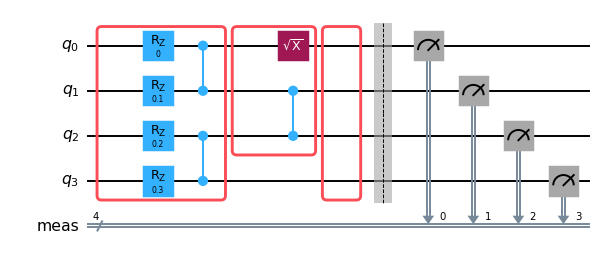

In [ ]:
circuit = QuantumCircuit(4)

with circuit.box([Twirl()]):
    for idx in range(4):
        circuit.rz(0.1 * idx, idx)
    circuit.cz(0, 1)
    circuit.cz(2, 3)

with circuit.box([Twirl()]):
    circuit.sx(0)
    circuit.cz(1, 2)

with circuit.box([Twirl(decomposition="rzrx", dressing="right")]):
    circuit.noop(0, 1, 2, 3)

circuit.measure_all()

circuit.draw("mpl", fold=500, scale=0.7)

### Building a Template Circuit

Samplomatic's `build()` function accepts a base circuit containing annotated boxes, 
and returns a template circuit and a samplex. The boxes have been removed and replaced with
parametric templates that are able to implement the dressing.
The intention is that the template circuit is what's actually sent to the low-level
compiler for eventual hardware execution.

In this example, you can see that each of the three boxes has been replaced, according 
to the configuration of the respective `Twirl`s, and everything has been sandwhiched with
`L`eft and `R`ight barriers. 
The dressing is further separated from the entangling content by a `M`iddle barriers.
You can see that both decomposition modes are used in this example.

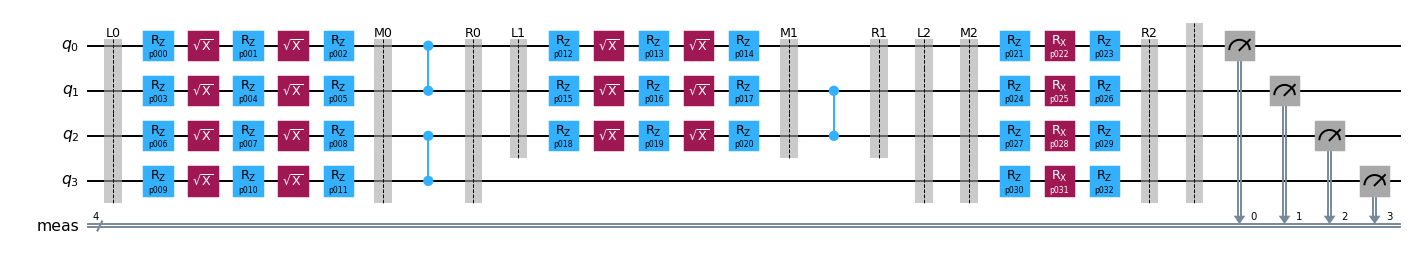

In [14]:
template, samplex = build(circuit)

template.draw("mpl", fold=500, scale=0.7)

### Build Errors

Certain box content is disallowed by the annotations of the box, and including it will result in build errors.
In the future, this can be implemented as validation-against-annotations rather than waiting until build.

For example, we can't put a single qubit gate past an entangler in a left-dressed box, otherwise it won't be
composable with the dressing:

In [ ]:
circuit = QuantumCircuit(2)

with circuit.box([Twirl()]):
    circuit.cx(0, 1)
    circuit.sx(1)

try:
    build(circuit)
except Exception as exc:
    print(repr(exc))

RuntimeError('Cannot handle single-qubit gate to the right of entangler when dressing=left.')


Similarly, we can't right-dress a box containing measurements:

In [ ]:
circuit = QuantumCircuit(2)

with circuit.box([Twirl(dressing="right")]):
    circuit.measure_all()

try:
    build(circuit)
except Exception as exc:
    print(repr(exc))

SamplexBuildError('Found an emission without a collector on subsystems {(0,), (1,)}.')
